In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pyarrow as pa
from datetime import datetime, timedelta
from dateutil import rrule
import gcsfs
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
datasets = ["2023-05"]
bucket_name = "prediswiss-parquet-data"

In [4]:
fs_gcs = gcsfs.GCSFileSystem()
dataframes = []
for dataset in datasets:
    path = bucket_name + "/" + dataset + ".parquet"
    table = pq.read_table(path, filesystem=fs_gcs)
    df = table.to_pandas()
    dataframes.append(df)
df = pd.concat(dataframes)

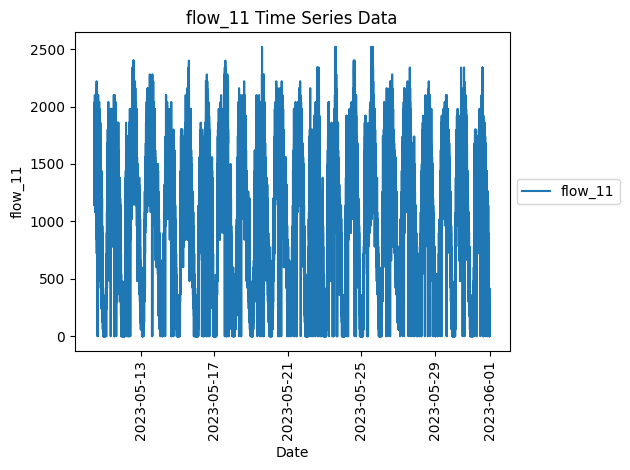

In [5]:
# Specify the parameters
id = 'CH:0542.05'
target = 'flow_11'
date = 'publication_date'

# Filter the DataFrame based on the specified id
filtered_df = df[df['id'] == id].copy()

# Convert the 'publication_date' column to datetime
filtered_df[date] = pd.to_datetime(filtered_df[date])

# Convert the 'flow_11' column to numeric type
filtered_df[target] = pd.to_numeric(filtered_df[target], errors='coerce')

filtered_df = filtered_df[[date, target]]

# Set 'publication_date' as the index
filtered_df.set_index(date, inplace=True)

# Resample the data to the desired frequency (e.g., minute 'T' or second 'S') and calculate the mean
flow_11_data = filtered_df.resample('T').mean().fillna(0)

# Split the data into training and testing sets
flow_11_data_train = flow_11_data.iloc[:24816]
flow_11_data_test = flow_11_data.iloc[24817:]

# Plot the time series data
plt.plot(flow_11_data.index, flow_11_data[target])
plt.xlabel('Date')
plt.ylabel(target)
plt.title(f'{target} Time Series Data')
plt.xticks(rotation=90)
plt.legend([target], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

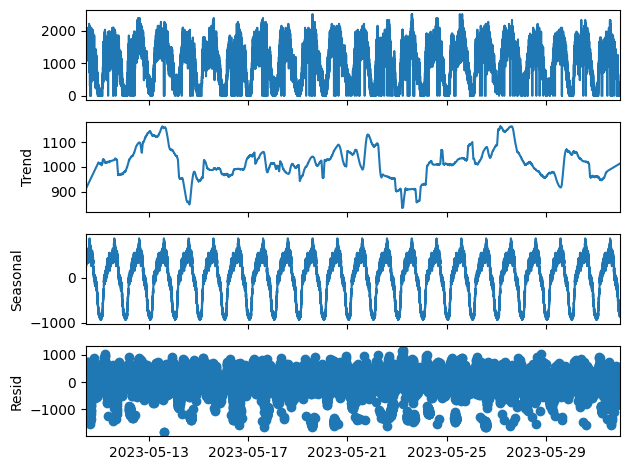

In [23]:
import statsmodels.api as sm

decompfreq = 60*24
ts_decomposed = sm.tsa.seasonal_decompose(flow_11_data, model='additive', extrapolate_trend=True, period=decompfreq)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid

ts_decomposed.plot()
plt.show()

In [27]:
import pmdarima as pm

model = pm.auto_arima(ts_trend,start_p=1, d=1, start_q=1,
                            max_p=5, max_q=5,
                            m=5,
                            seasonal=False, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
model.fit(ts_trend)
trend_pred_auto = model.predict(n_periods=len(flow_11_data_test))

c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (5) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [29]:
model = pm.auto_arima(ts_seasonal,start_p=1, d=0, start_q=1,
                            max_p=4, max_q=4,
                            m=4,
                            seasonal=True, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
model.fit(ts_seasonal)

pred = model.predict(n_periods=len(flow_11_data_test))
ts_pred_decompose = trend_pred_auto * pred

c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(0,0,0)(2,0,1)[4] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\statsmodels\tsa\sta

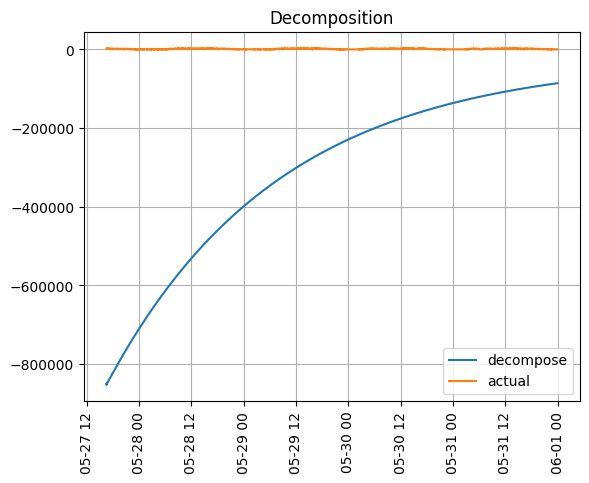

In [30]:
plt.plot(flow_11_data_test.index, ts_pred_decompose, label='decompose')
plt.plot(flow_11_data_test, label='actual')
plt.title('Decomposition')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-05-31 23:57:00+00:00     111.435853
2023-05-31 23:58:00+00:00     110.030087
2023-05-31 23:59:00+00:00     109.902402
2023-06-01 00:00:00+00:00     109.799041
2023-06-01 00:01:00+00:00     109.696142
                                ...     
2023-06-21 19:52:00+00:00   -2976.067731
2023-06-21 19:53:00+00:00   -2976.170620
2023-06-21 19:54:00+00:00   -2976.273510
2023-06-21 19:55:00+00:00   -2976.376400
2023-06-21 19:56:00+00:00   -2976.479289
Freq: T, Name: predicted_mean, Length: 30000, dtype: float64


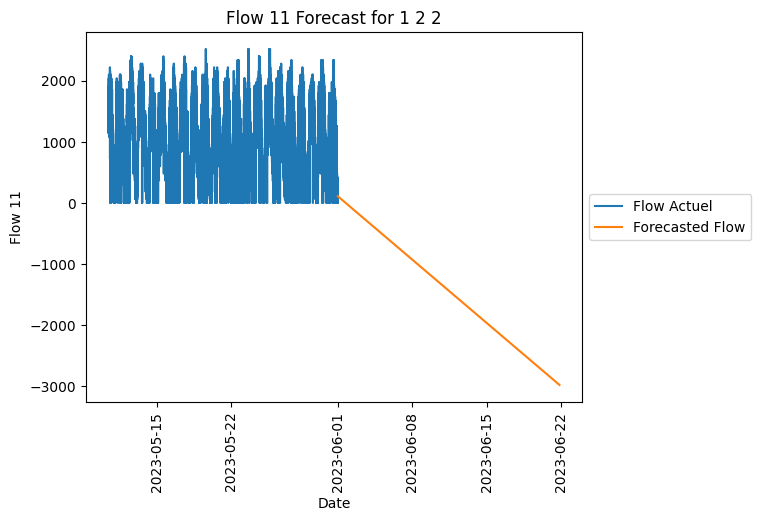

<Figure size 1200x600 with 0 Axes>

In [63]:
model = ARIMA(flow_11_data, order=(1, 2, 2))
# Fit the model to the data
model_fit = model.fit()

# Forecast future values
forecast_values = model_fit.forecast(30000)

print(forecast_values)

# Plot the original data and the forecasted values
plt.plot(flow_11_data, label='Original Data')
plt.plot(forecast_values, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Flow 11')
plt.title('Flow 11 Forecast for ' + " ".join(str(element) for element in (1,2,2)))
# Adjust the legend orientation and position
plt.legend(['Flow Actuel', 'Forecasted Flow'], loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis tick labels for vertical orientation
plt.xticks(rotation=90)

# Adjust the figure size to extend the width
plt.figure(figsize=(12, 6))
plt.show()

In [2]:
dataset = ["2023"]
bucket_name_daily = "prediswiss-parquet-data-daily"

In [8]:
fs_gcs = gcsfs.GCSFileSystem()
daily_dataframes = []
for data in dataset:
    path = bucket_name_daily + "/" + data + ".parquet"
    table = pq.read_table(path, filesystem=fs_gcs)
    tmp_df = table.to_pandas()
    daily_dataframes.append(tmp_df)
daily_df = pd.concat(daily_dataframes)
display(daily_df)

,publication_date,id,flow_1,flow_11,flow_21,speed_2,speed_12,speed_22
0,2023-06-06T22:56:18.082671Z,CH:0542.05,0,120,0,None,111.5,None
1,2023-06-06T22:56:18.082671Z,CH:0026.03,0,60,0,None,113,None
2,2023-06-06T22:56:18.082671Z,CH:0301.03,0,120,0,None,96,None
3,2023-06-06T22:56:18.082671Z,CH:0026.02,0,180,0,None,96.6999969,None
4,2023-06-06T22:56:18.082671Z,CH:0301.02,0,0,0,None,None,None
...,...,...,...,...,...,...,...,...
17902698,2023-06-07T20:57:18.109986Z,CH:0748.02,0,0,0,None,None,None
17902699,2023-06-07T20:57:18.109986Z,CH:0318.01,0,180,0,None,121.699997,None
17902700,2023-06-07T20:57:18.109986Z,CH:0505.01,0,360,0,None,119,None
17902701,2023-06-07T20:57:18.109986Z,CH:0505.03,0,600,0,None,123.199997,None


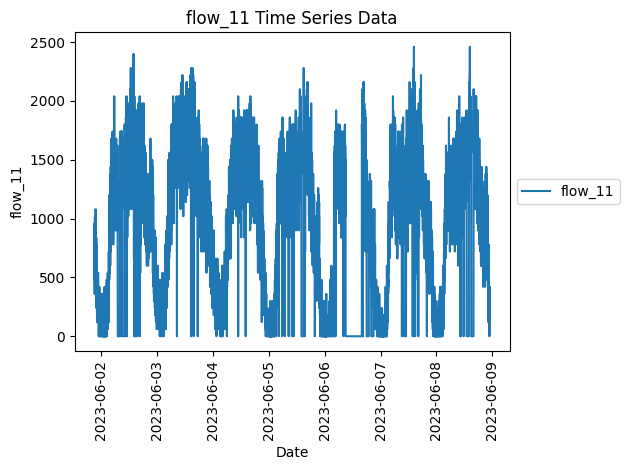

In [9]:
# Specify the parameters
id = 'CH:0542.05'
target = 'flow_11'
date = 'publication_date'

# Filter the DataFrame based on the specified id
filtered_df = daily_df[daily_df['id'] == id].copy()

# Convert the 'publication_date' column to datetime
filtered_df[date] = pd.to_datetime(filtered_df[date])

# Convert the 'flow_11' column to numeric type
filtered_df[target] = pd.to_numeric(filtered_df[target], errors='coerce')

filtered_df = filtered_df[[date, target]]

# Set 'publication_date' as the index
filtered_df.set_index(date, inplace=True)

# Resample the data to the desired frequency (e.g., minute 'T' or second 'S') and calculate the mean
flow_11_data = filtered_df.resample('T').mean().fillna(0)

# Split the data into training and testing sets
flow_11_data_train = flow_11_data.iloc[:24816]
flow_11_data_test = flow_11_data.iloc[24817:]

# Plot the time series data
plt.plot(flow_11_data.index, flow_11_data[target])
plt.xlabel('Date')
plt.ylabel(target)
plt.title(f'{target} Time Series Data')
plt.xticks(rotation=90)
plt.legend([target], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

c:\Users\chiff\miniconda3\envs\TB\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-06-08 22:57:00+00:00    253.228191
2023-06-08 22:58:00+00:00    253.030411
2023-06-08 22:59:00+00:00    252.990223
2023-06-08 23:00:00+00:00    252.949696
2023-06-08 23:01:00+00:00    252.909171
                                ...    
2023-06-29 18:52:00+00:00   -962.496551
2023-06-29 18:53:00+00:00   -962.537076
2023-06-29 18:54:00+00:00   -962.577602
2023-06-29 18:55:00+00:00   -962.618128
2023-06-29 18:56:00+00:00   -962.658653
Freq: T, Name: predicted_mean, Length: 30000, dtype: float64


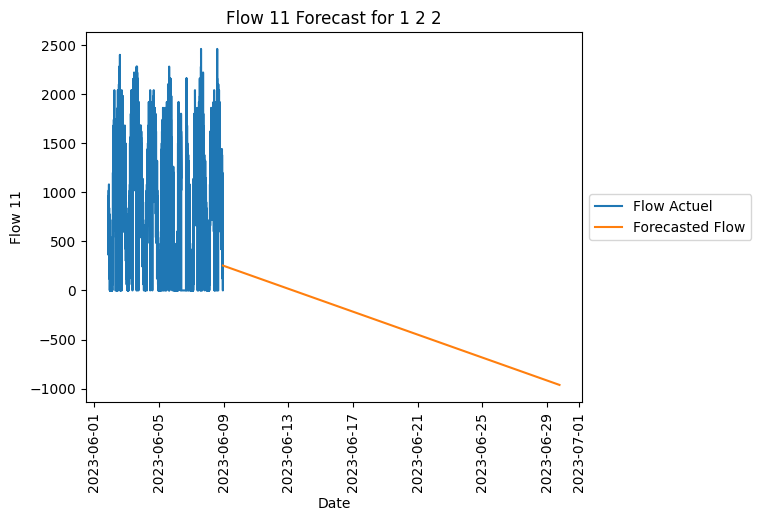

<Figure size 1200x600 with 0 Axes>

In [12]:
model = ARIMA(flow_11_data, order=(1, 2, 2))
# Fit the model to the data
model_fit = model.fit()

# Forecast future values
forecast_values = model_fit.forecast(30000)

print(forecast_values)

# Plot the original data and the forecasted values
plt.plot(flow_11_data, label='Original Data')
plt.plot(forecast_values, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Flow 11')
plt.title('Flow 11 Forecast for ' + " ".join(str(element) for element in (1,2,2)))
# Adjust the legend orientation and position
plt.legend(['Flow Actuel', 'Forecasted Flow'], loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis tick labels for vertical orientation
plt.xticks(rotation=90)

# Adjust the figure size to extend the width
plt.figure(figsize=(12, 6))
plt.show()